<a href="https://colab.research.google.com/github/08Arno30/COS791-A2/blob/main/src/u21457451_COS791_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

working_dir = "/content/drive/MyDrive/Honours/Semester\ 2/COS791/Assignments/COS791-A2/"
%cd $working_dir

Mounted at /content/drive
/content/drive/MyDrive/Honours/Semester 2/COS791/Assignments/COS791-A2


# Installments

In [3]:
!pip install pythreshold

  Preparing metadata (setup.py) ... done
  Created wheel for pythreshold: filename=pythreshold-0.3.1-py3-none-any.whl size=25022 sha256=eef9a180c0e04c6404a6fdd32b3df1e4fb7dc3deba31e4d4bef1e0bbe04e640e
  Stored in directory: /root/.cache/pip/wheels/ad/e3/3e/8e8bcadca9c0f03f52b52c05ea7b74cf20dcadb8e69317bffd
Successfully built pythreshold


# Imports

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_multiotsu
from pythreshold.global_th.entropy import kapur_multithreshold
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Introduction

This assignment compares the performance of two optimisation techniques, Simulated Annealing (SA) and Variable Neighbourhood Search (VNS), in solving the multilevel thresholding problem for image segmentation. Multilevel thresholding involves splitting a picture into various regions based on pixel intensity levels, which is an important task in many image processing applications. It prioritises thresholding at levels \(k = 2, 3, 4, 5 \) for a batch of five images.

The Otsu technique and Kapur's entropy are two well-known objective functions used to assess thresholding quality. These methods will be used to determine the ideal thresholds for segmenting the photos. The goal is to see how well the SA and VNS algorithms work in determining suitable thresholds across different levels and images.

In addition, a table will be produced that summarises the threshold values and the relevant quality metrics obtained from both methods. Furthermore, for each image, at least one pair of Otsu and Kapur technique results will be visualised to better explain the segmentation outcomes.

# Helper Functions

## Objective Functions

### Otsu Thresholding

In [5]:
def perform_otsu(grey_image, num_thresholds):
  # Get multiple threshold values
  thresh_vals = threshold_multiotsu(grey_image, classes=num_thresholds)

  # Segment the image
  segmented_image = np.digitize(grey_image, bins=thresh_vals)

  return segmented_image

### Kapur Entropy

In [6]:
def perform_kapur(grey_image, num_thresholds):
  # Get multiple threshold values
  thresh_vals = kapur_multithreshold(grey_image, num_thresholds)

  # Segment the image
  segmented_image = np.digitize(grey_image, bins=thresh_vals)

  return segmented_image

## Simulated Annealing (SA)

In [18]:
def perform_sa(image, k, evaluation_method, objective, bounds, num_iterations, step_size, initial_temp):
  num_thresholds = k - 1

  # Initialise the solution
  best_solution = np.sort(np.random.uniform(bounds[0], bounds[1], num_thresholds))

  # Segment the image
  if objective == 'otsu':
    segmented_image = perform_otsu(image, num_thresholds)
  elif objective == 'kapur':
    segmented_image = perform_kapur(image, num_thresholds)
  else:
    raise ValueError("Objective function not supported. It can only be 'otsu' or 'kapur'.")

  best_segmented_image = segmented_image.copy()

  # Evaluate the initial solution
  if evaluation_method == 'ssim':
    best_evaluation = calculate_ssim(image, segmented_image)
  else:
    best_evaluation = calculate_psnr(image, segmented_image)

  current_solution = best_solution.copy()
  current_solution_evaluation = best_evaluation
  scores = [best_evaluation]

  for i in range(num_iterations):
    # Decrease temperature
    decreased_temp = initial_temp * (1 - (i / num_iterations))

    # Generate a new camdidate solution
    candidate = current_solution + np.random.uniform(-step_size, step_size, num_thresholds)
    candidate = np.clip(candidate, bounds[0], bounds[1])
    candidate = np.sort(candidate)

    # Segment the image using the candidate thresholds
    if objective == 'otsu':
      candidate_segmented = perform_otsu(image, num_thresholds)
    else:
      candidate_segmented = perform_kapur(image, num_thresholds)

    # Evaluate the candidate solution
    if evaluation_method == 'ssim':
      candidate_evaluation = calculate_ssim(image, candidate_segmented)
    else:
      candidate_evaluation = calculate_psnr(image, candidate_segmented)

    # Accept the new solution if it's better
    if candidate_evaluation > best_evaluation or np.random.rand() < np.exp((best_evaluation - candidate_evaluation) / decreased_temp):
      current_solution, current_solution_evaluation = candidate, candidate_evaluation

      if candidate_evaluation > best_evaluation:
        best_solution, best_evaluation, best_segmented_image = candidate, candidate_evaluation, candidate_segmented.copy()
        scores.append(best_evaluation)

    # Print progress
    if i % 100 == 0:
      print(f"Iteration {i}, Temperature {decreased_temp:.3f}, Best Evaluation {best_evaluation:.5f}")

  return [best_solution, best_evaluation, best_segmented_image, scores]


## Variable Neighbourhood Search (VNS)

In [20]:
def perform_vns(image, k, evaluation_method, objective, bounds, num_iterations, step_size):
  num_thresholds = k - 1

  def vns_local_search(current_solution):
    new_solution = current_solution + np.random.uniform(-step_size, step_size, num_thresholds)
    new_solution = np.clip(new_solution, bounds[0], bounds[1])
    new_solution = np.sort(new_solution)
    return new_solution

  current_solution = np.sort(np.random.uniform(bounds[0], bounds[1], num_thresholds))
  best_solution = current_solution.copy()

  # Segment the image
  if objective == 'otsu':
    segmented_image = perform_otsu(image, num_thresholds)
  elif objective == 'kapur':
    segmented_image = perform_kapur(image, num_thresholds)
  else:
    raise ValueError("Objective function not supported. It can only be 'otsu' or 'kapur'.")

  best_segmented_image = segmented_image.copy()

  # Evaluate the initial solution
  if evaluation_method == 'ssim':
    best_evaluation = calculate_ssim(image, segmented_image)
  else:
    best_evaluation = calculate_psnr(image, segmented_image)

  scores = [best_evaluation]

  for i in range(num_iterations):
    # Generate a new solution through local search
    new_solution = vns_local_search(current_solution)

    # Segmentt the image
    if objective == 'otsu':
      new_segmented_image = perform_otsu(image, num_thresholds)
    elif objective == 'kapur':
      new_segmented_image = perform_kapur(image, num_thresholds)

    # Evaluate the new solution
    if evaluation_method == 'ssim':
      new_evaluation = calculate_ssim(image, new_segmented_image)
    else:
      new_evaluation = calculate_psnr(image, new_segmented_image)

    # Update if the new solution is beter
    if new_evaluation > best_evaluation:
      best_solution, best_evaluation, best_segmented_image = new_solution, new_evaluation, new_segmented_image.copy()
      scores.append(best_evaluation)

    current_solution = new_solution

    # Print progress
    if i % 100 == 0:
      print(f"Iteration {i}, Best Evaluation {best_evaluation:.5f}")

  return [best_solution, best_evaluation, best_segmented_image, scores]


## Mask the image

In [14]:
def mask_image(original_image, mask_value):
  red = np.zeros_like(original_image)
  green = np.zeros_like(original_image)
  blue = np.zeros_like(original_image)

  red = original_image[:,:,0] * mask_value
  green = original_image[:,:,1] * mask_value
  blue = original_image[:,:,2] * mask_value

  masked_image = np.dstack((red, green, blue))
  return masked_image

## Calculate SSIM

In [9]:
def calculate_ssim(original_image, masked_image):
  return ssim(original_image, masked_image, data_range=original_image.max() - original_image.min())

## Calculate PSNR

In [10]:
def calculate_psnr(original_image, masked_image):
  return psnr(original_image, masked_image)

## Display images

In [21]:
def display_images(original_images, segmented_image, objective, algorithm, evaluation_method, results_path, file_name, k):
  sa_segmented_image = segmented_image.copy()
  fig, axs = plt.subplots(len(original_images), 4, figsize=(10, 10))
  results_path = results_path + f"{objective}_{algorithm}_{evaluation_method}_{file_name}_{k}"

  for i, image in enumerate(original_images):
    # Original image
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    plt.imsave(results_path + f"_original.png", image)

    # Grayscale image
    grey_img = rgb2gray(image)
    axs[i, 1].imshow(grey_img, cmap='gray')
    axs[i, 1].set_title('Grayscale')
    axs[i, 1].axis('off')
    plt.imsave(results_path + f"_grayscale.png", grey_img, cmap='gray')

    # Segmented image
    axs[i, 2].imshow(segmented_image, cmap='jet')
    axs[i, 2].set_title(f'Segmented ({objective.capitalize()})')
    axs[i, 2].axis('off')
    plt.imsave(results_path + f"_segmented.png", segmented_image, cmap='jet')

    # Masked image
    masked_img = mask_image(image, segmented_img)
    axs[i, 3].imshow(masked_img)
    axs[i, 3].set_title('Masked')
    axs[i, 3].axis('off')
    plt.imsave(results_path + f"_masked.png", masked_img)

  plt.tight_layout()

  plt.show()

## Save Results

In [ ]:
def save_results(best_solution, best_evaluation, objective, algorithm, evaluation_method, results_path, file_name, k):
  file_path = results_path + f"{objective}_{algorithm}_{evaluation_method}_{file_name}_{k}.txt"
  with open(file_path, 'w') as f:
    f.write(f"File Name: {file_name}\n")
    f.write(f"K: {k}\n")
    f.write(f"Objective: {objective}\n")
    f.write(f"Algorithm: {algorithm}\n")
    f.write(f"Evaluation Method: {evaluation_method}\n")
    f.write(f"Best Solution: {best_solution}\n")
    f.write(f"Best Evaluation: {best_evaluation}\n")

# Main Program

In [ ]:
def run_program(original_images, file_names, parameters, output_path):
  objective = parameters['objective']
  algorithm = parameters['algorithm']
  evaluation_method = parameters['evaluation_method']
  k = parameters['k']
  bounds = parameters['bounds']
  num_iterations = parameters['num_iterations']
  step_size = parameters['step_size']
  initial_temp = parameters['initial_temp']

  if objective == 'otsu' and algorithm == 'sa' and evaluation_method == 'ssim':
    results_path = output_path + "OTSU/SA_SSIM/"
  elif objective == 'otsu' and algorithm == 'sa' and evaluation_method == 'psnr':
    results_path = output_path + "OTSU/SA_PSNR/"
  elif objective == 'otsu' and algorithm == 'vns' and evaluation_method == 'ssim':
    results_path = output_path + "OTSU/VNS_SSIM/"
  elif objective == 'otsu' and algorithm == 'vns' and evaluation_method == 'psnr':
    results_path = output_path + "OTSU/VNS_PSNR/"
  elif objective == 'kapur' and algorithm == 'sa' and evaluation_method == 'ssim':
    results_path = output_path + "KAPUR/SA_SSIM/"
  elif objective == 'kapur' and algorithm == 'sa' and evaluation_method == 'psnr':
    results_path = output_path + "KAPUR/SA_PSNR/"
  elif objective == 'kapur' and algorithm == 'vns' and evaluation_method == 'ssim':
    results_path = output_path + "KAPUR/VNS_SSIM/"
  elif objective == 'kapur' and algorithm == 'vns' and evaluation_method == 'psnr':
    results_path = output_path + "KAPUR/VNS_PSNR/"
  else:
    raise ValueError("Invalid parameters")

  if not os.path.exists(results_path):
    os.makedirs(results_path)

  for i, image in enumerate(original_images):
    for j, k_value in enumerate(k):
      if algorithm == 'sa':
        # Perform Simulated Annealing
        sa_results = perform_sa(image, k_value, evaluation_method, objective, bounds, num_iterations, step_size, initial_temp)
        sa_best_solution, sa_best_evaluation, sa_segmented_image, sa_scores = sa_results

        # Save results
        save_results(sa_best_solution, sa_best_evaluation, objective, algorithm, evaluation_method, results_path, file_names[i], k_value)

        # Display images
        display_images(original_images, sa_segmented_image, objective, algorithm, evaluation_method, results_path, file_names[i], k_value)
      elif algorithm == 'vns':
        # Perform Variable Neighbourhood Search
        vns_results = perform_vns(image, k_value, evaluation_method, objective, bounds, num_iterations, step_size)
        vns_best_solution, vns_best_evaluation, vns_segmented_image, vns_scores = vns_results

        # Save results
        save_results(vns_best_solution, vns_best_evaluation, objective, algorithm, evaluation_method, results_path, file_names[i], k_value)

        # Display images
        display_images(original_images, vns_segmented_image, objective, algorithm, evaluation_method, results_path, file_names[i], k_value)
      else:
        raise ValueError("Invalid algorithm")

NameError: name 'mask_image' is not defined

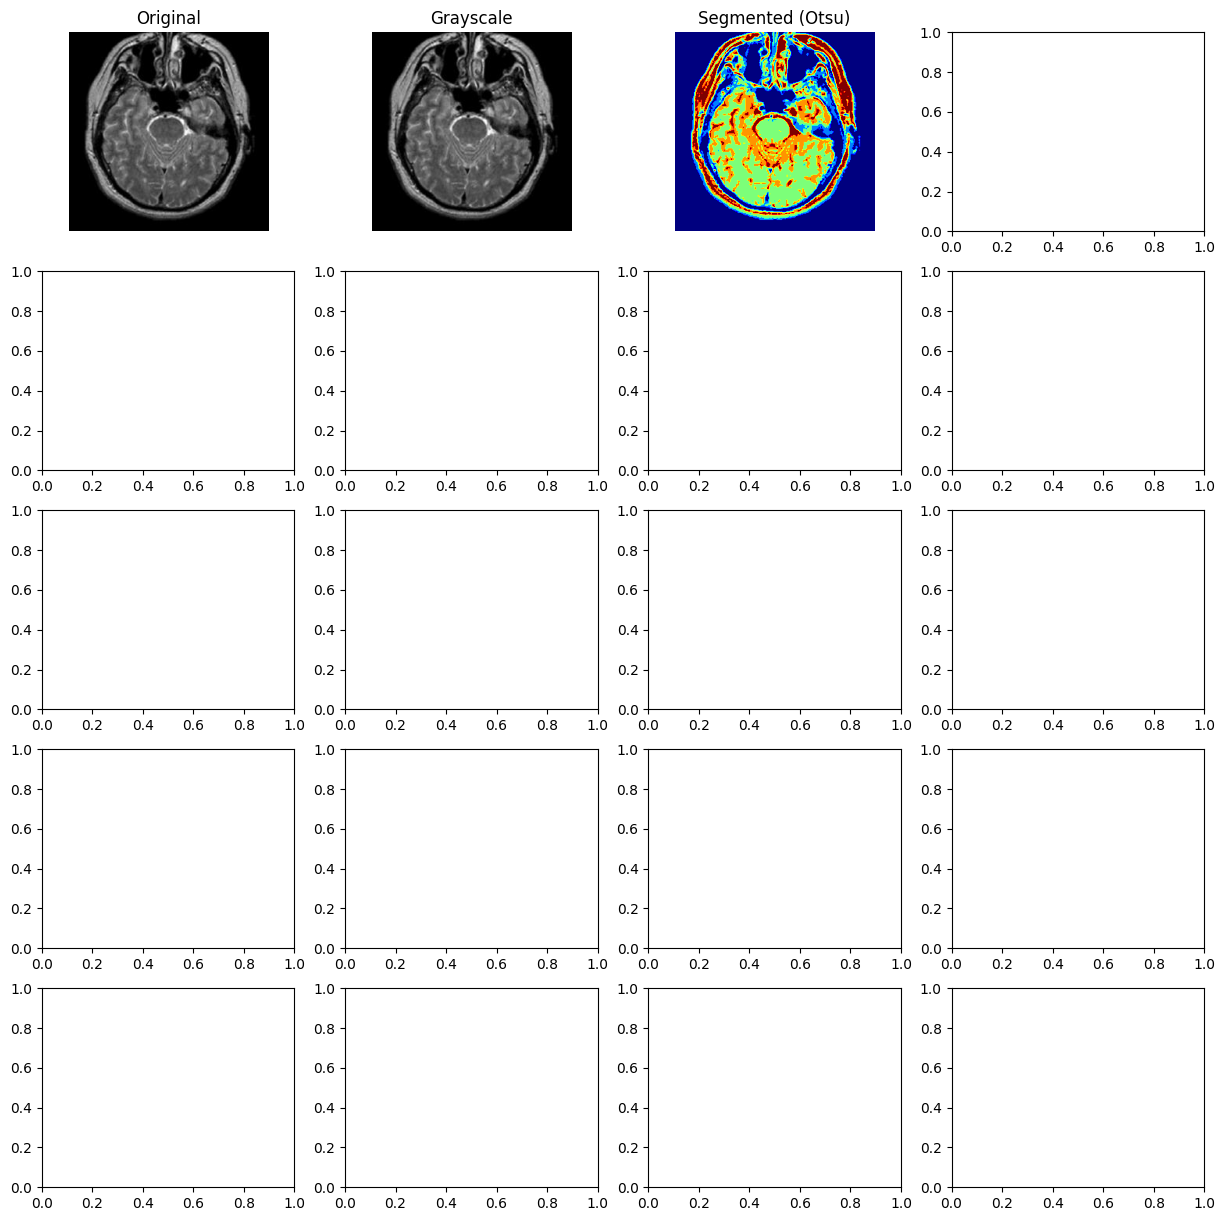

In [11]:
seed = 99
np.random.seed(seed)

original_images = []
input_path = "./data/input/"
output_path = "./data/output/"

# Parameters
objective = 'otsu'
algorithm = 'sa'
evaluation_method = 'ssim'
k = [2, 3, 4, 5]
bounds = [0, 255]
num_iterations = 1000
step_size = 10
initial_temp = 100

parameters = {
  'objective': objective,
  'algorithm': algorithm,
  'evaluation_method': evaluation_method,
  'k': k,
  'bounds': bounds,
  'num_iterations': num_iterations,
  'step_size': step_size,
  'initial_temp': initial_temp
}

if not os.path.exists(output_path):
  os.makedirs(output_path)

file_names = []

for filename in os.listdir(input_path):
  original_images.append(imread(input_path + filename))
  file_names.append(filename)

run_program(original_images, file_names, parameters, output_path)

KeyboardInterrupt: 

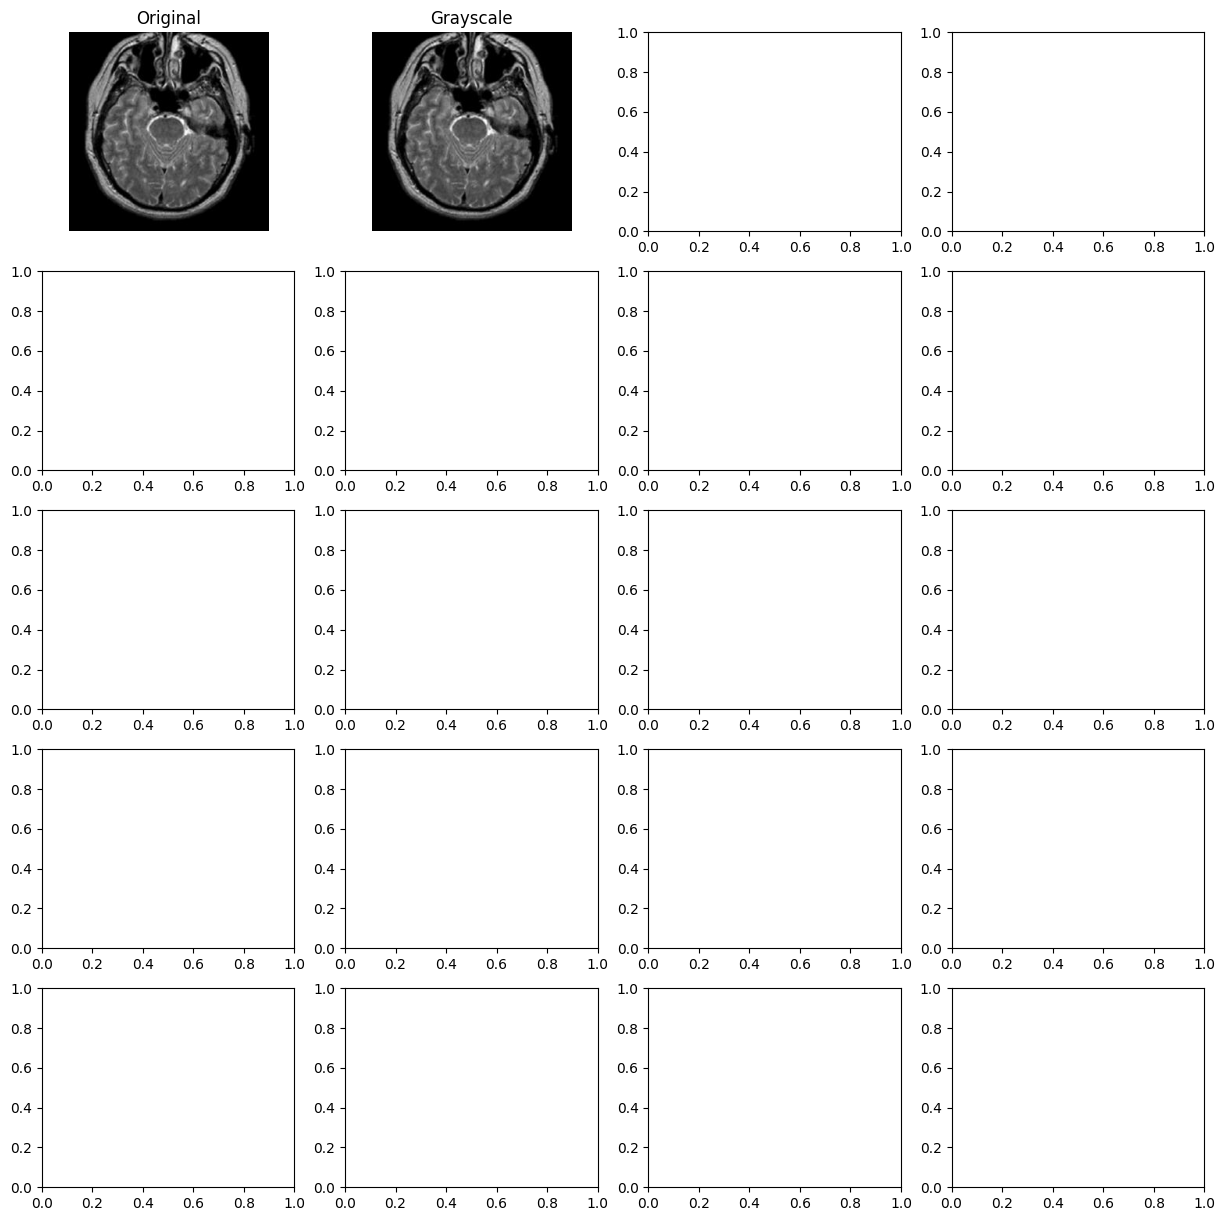

In [55]:
fig, axs = plt.subplots(len(original_images), 4, figsize=(15, 15))

for i, image in enumerate(original_images):
  # Original image
  axs[i, 0].imshow(image)
  axs[i, 0].set_title('Original')
  axs[i, 0].axis('off')

  # Grayscale image
  grey_img = rgb2gray(image)
  axs[i, 1].imshow(grey_img, cmap='gray')
  axs[i, 1].set_title('Grayscale')
  axs[i, 1].axis('off')

  # Segmented image
  segmented_img = perform_kapur(grey_img, num_thresholds=5)
  axs[i, 2].imshow(segmented_img, cmap='jet')
  axs[i, 2].set_title('Segmented (Otsu)')
  axs[i, 2].axis('off')

  # Masked image
  masked_img = mask_image(image, segmented_img)
  axs[i, 3].imshow(masked_img)
  axs[i, 3].set_title('Masked')
  axs[i, 3].axis('off')

plt.tight_layout()

plt.show()